Umbral elegido por CV (TRAIN): 0.42

=== TEST (RF 80/20) ===
AUC: 0.9104611431153282
PR-AUC: 0.9047096836453014
Accuracy: 0.8156182212581344
Precision: 0.7790262172284644
Recall: 0.8888888888888888
F1: 0.8303393213572854
MCC: 0.6369408787029652
CM [[TN FP],[FN TP]]: [[672, 236], [104, 832]]


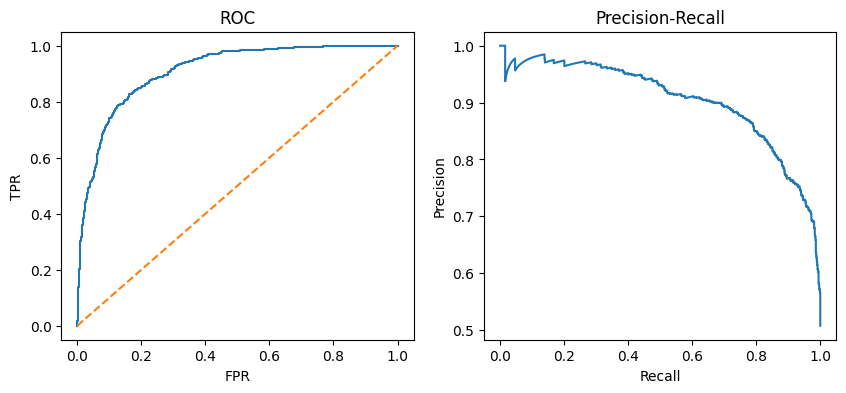

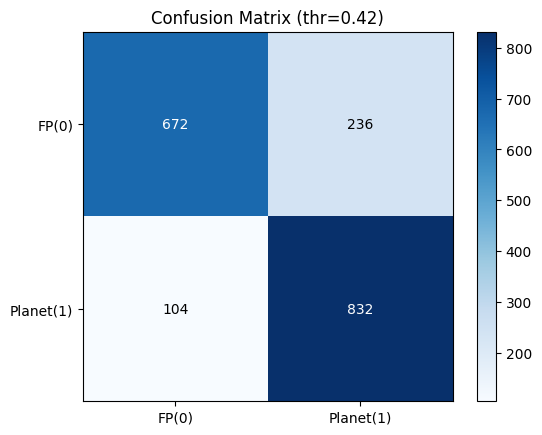


Top 15 features (RF):
duty_cycle       0.200912
koi_prad         0.165905
koi_period       0.074858
log_period       0.071733
koi_impact       0.067450
koi_model_snr    0.052127
koi_teq          0.051148
log_depth        0.048737
koi_depth        0.048457
depth_frac       0.046551
koi_duration     0.046423
rprstar_est      0.039058
koi_steff        0.030120
koi_slogg        0.020489
koi_srad         0.019763
dtype: float64


In [ ]:
# =========================
# RF 80/20 con umbral elegido por CV en TRAIN y evaluación en TEST
# =========================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve, roc_curve,
    confusion_matrix, classification_report, accuracy_score, precision_score,
    recall_score, f1_score, matthews_corrcoef
)

# ---------- CONFIG ----------
CSV_IN = "/content/kepler_clean.csv"
RANDOM_STATE = 42
USE_FPFLAGS = False
GOAL_RECALL = 0.90

# ---------- Carga + features derivadas ----------
df = pd.read_csv(CSV_IN)
assert "label" in df.columns, "Falta 'label' en el CSV."

# Derivadas consistentes con tu entrenamiento
def add_derivatives(d):
    d = d.copy()
    if {"koi_period","koi_duration","koi_depth"}.issubset(d.columns):
        with np.errstate(divide="ignore", invalid="ignore"):
            d["duty_cycle"] = pd.to_numeric(d["koi_duration"], errors="coerce") / (
                pd.to_numeric(d["koi_period"], errors="coerce") * 24.0)
    if "koi_depth" in d.columns:
        depth = pd.to_numeric(d["koi_depth"], errors="coerce")
        d["depth_frac"]  = depth.clip(lower=1e-9) * 1e-6
        d["rprstar_est"] = np.sqrt(d["depth_frac"])
        d["log_depth"]   = np.log10(depth.clip(lower=1e-9))
    if "koi_period" in d.columns:
        period = pd.to_numeric(d["koi_period"], errors="coerce")
        d["log_period"]  = np.log10(period.clip(lower=1e-9))
    return d

df = add_derivatives(df)

ban = {"label","object_id","kepoi_name","kepler_name","koi_name","kepid","source","koi_disposition"}
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in num_cols if c not in ban]
if not USE_FPFLAGS:
    features = [c for c in features if not c.startswith("koi_fpflag_")]

X_all = df[features].apply(pd.to_numeric, errors="coerce")
y_all = df["label"].astype(int)

# Split 80/20 estratificado
X_tr, X_te, y_tr, y_te = train_test_split(
    X_all, y_all, test_size=0.20, random_state=RANDOM_STATE, stratify=y_all
)

# Imputación usando medianas SOLO del train (evita fuga)
medians = X_tr.median(numeric_only=True)
X_tr = X_tr.fillna(medians)
X_te = X_te.fillna(medians)

# Modelo RF (tus hiperparámetros estables)
rf = RandomForestClassifier(
    n_estimators=500, max_depth=12, min_samples_leaf=5,
    max_features="sqrt", random_state=RANDOM_STATE, n_jobs=-1
).fit(X_tr, y_tr)

# Elegimos umbral en TRAIN por CV (sin tocar el test)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
oof_proba_tr = cross_val_predict(rf, X_tr, y_tr, cv=cv, method="predict_proba", n_jobs=-1)[:,1]

ths = np.linspace(0.20, 0.80, 121)
def pick_threshold(y, p, goal_recall=None):
    f1s, recs = [], []
    for t in ths:
        yhat = (p >= t).astype(int)
        f1s.append(f1_score(y, yhat))
        recs.append(recall_score(y, yhat))
    t_maxF1 = float(ths[int(np.argmax(f1s))])
    if goal_recall is None:
        return t_maxF1
    mask = np.array(recs) >= goal_recall
    return float(ths[mask][np.argmax(np.array(f1s)[mask])]) if mask.any() else t_maxF1

thr = pick_threshold(y_tr, oof_proba_tr, goal_recall=GOAL_RECALL)
print(f"Umbral elegido por CV (TRAIN): {thr:.2f}")

# Métricas en TEST
p_te = rf.predict_proba(X_te)[:,1]
yhat = (p_te >= thr).astype(int)

def show_metrics(y, p, yhat, title):
    print(f"\n=== {title} ===")
    print("AUC:", roc_auc_score(y, p))
    print("PR-AUC:", average_precision_score(y, p))
    print("Accuracy:", accuracy_score(y, yhat))
    print("Precision:", precision_score(y, yhat))
    print("Recall:", recall_score(y, yhat))
    print("F1:", f1_score(y, yhat))
    print("MCC:", matthews_corrcoef(y, yhat))
    print("CM [[TN FP],[FN TP]]:", confusion_matrix(y, yhat).tolist())

show_metrics(y_te, p_te, yhat, "TEST (RF 80/20)")

# Curvas y Confusion Matrix
fpr, tpr, _ = roc_curve(y_te, p_te)
prec, rec, _ = precision_recall_curve(y_te, p_te)

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(fpr, tpr); ax[0].plot([0,1],[0,1],"--")
ax[0].set_title("ROC"); ax[0].set_xlabel("FPR"); ax[0].set_ylabel("TPR")
ax[1].plot(rec, prec); ax[1].set_title("Precision-Recall")
ax[1].set_xlabel("Recall"); ax[1].set_ylabel("Precision")
plt.show()

cm = confusion_matrix(y_te, yhat)
plt.imshow(cm, cmap="Blues"); plt.colorbar()
plt.xticks([0,1], ["FP(0)","Planet(1)"]); plt.yticks([0,1], ["FP(0)","Planet(1)"])
plt.title(f"Confusion Matrix (thr={thr:.2f})")
for i in range(2):
    for j in range(2):
        plt.text(j,i,cm[i,j], ha="center", va="center",
                 color="white" if cm[i,j] > cm.max()/2 else "black")
plt.show()

# Importancias RF
imp = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
print("\nTop 15 features (RF):")
print(imp.head(15))


Umbrales VALID → maxF1=0.34 | hiRecall=0.29 → elegido=0.29

=== VALID (Stack RF+GB) @thr=0.29 ===
AUC: 0.9184151323468503
PR-AUC: 0.9201875765939185
Accuracy: 0.8177874186550976
Precision: 0.773224043715847
Recall: 0.907051282051282
F1: 0.8348082595870207
MCC: 0.644602485808427
CM [[TN FP],[FN TP]]: [[659, 249], [87, 849]]

=== TEST  (Stack RF+GB) @thr=0.29 ===
AUC: 0.9114130332467337
PR-AUC: 0.9067947197204792
Accuracy: 0.8053145336225597
Precision: 0.7541850220264317
Recall: 0.9145299145299145
F1: 0.8266537904394012
MCC: 0.6240729057994184
CM [[TN FP],[FN TP]]: [[629, 279], [80, 856]]


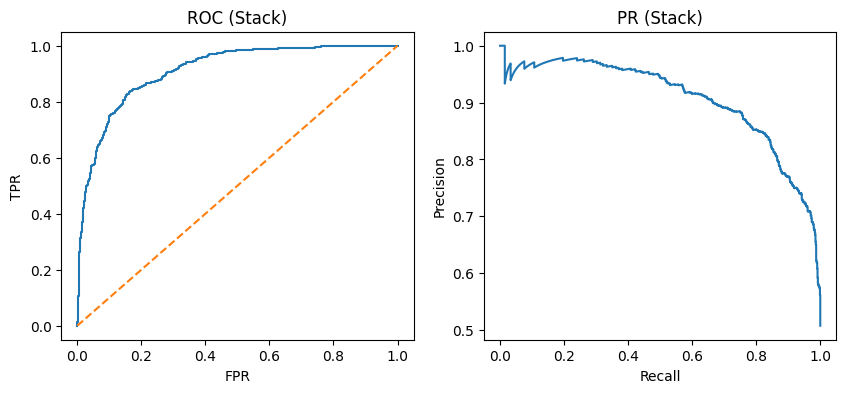


Top 10 features RF:
duty_cycle       0.198384
koi_prad         0.159326
log_period       0.074921
koi_period       0.074401
koi_impact       0.070775
koi_teq          0.050634
koi_model_snr    0.049298
koi_duration     0.048692
koi_depth        0.048617
depth_frac       0.047359
dtype: float64

Top 10 features GB:
koi_prad         0.314316
duty_cycle       0.276357
koi_model_snr    0.073053
koi_duration     0.054369
koi_steff        0.051040
log_period       0.042833
koi_impact       0.041830
koi_period       0.032156
koi_teq          0.026751
koi_srad         0.025249
dtype: float64


In [ ]:
# ============================================
# GB + Stacking (RF+GB) con 60/20/20 y umbral en VALID
# ============================================
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_curve, roc_curve,
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
)

# ---------- CONFIG ----------
CSV_IN = "/content/kepler_clean.csv"
RANDOM_STATE = 42
USE_FPFLAGS = False
GOAL_RECALL = 0.90

# ---------- Carga + derivadas ----------
df = pd.read_csv(CSV_IN)
assert "label" in df.columns, "Falta 'label' en el CSV."

def add_derivatives(d):
    d = d.copy()
    if {"koi_period","koi_duration","koi_depth"}.issubset(d.columns):
        with np.errstate(divide="ignore", invalid="ignore"):
            d["duty_cycle"] = pd.to_numeric(d["koi_duration"], errors="coerce") / (
                pd.to_numeric(d["koi_period"], errors="coerce") * 24.0)
    if "koi_depth" in d.columns:
        depth = pd.to_numeric(d["koi_depth"], errors="coerce")
        d["depth_frac"]  = depth.clip(lower=1e-9) * 1e-6
        d["rprstar_est"] = np.sqrt(d["depth_frac"])
        d["log_depth"]   = np.log10(depth.clip(lower=1e-9))
    if "koi_period" in d.columns:
        period = pd.to_numeric(d["koi_period"], errors="coerce")
        d["log_period"]  = np.log10(period.clip(lower=1e-9))
    return d

df = add_derivatives(df)

ban = {"label","object_id","kepoi_name","kepler_name","koi_name","kepid","source","koi_disposition"}
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
features = [c for c in num_cols if c not in ban]
if not USE_FPFLAGS:
    features = [c for c in features if not c.startswith("koi_fpflag_")]

X = df[features].apply(pd.to_numeric, errors="coerce")
y = df["label"].astype(int)

# Split 60/20/20
X_tmp, X_test, y_tmp, y_test = train_test_split(
    X, y, test_size=0.20, random_state=RANDOM_STATE, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_tmp, y_tmp, test_size=0.25, random_state=RANDOM_STATE, stratify=y_tmp
)  # 0.25 del 80% -> 20%

# Imputación con medianas de TRAIN
med = X_train.median(numeric_only=True)
X_train = X_train.fillna(med)
X_val   = X_val.fillna(med)
X_test  = X_test.fillna(med)

# Modelos base
rf = RandomForestClassifier(
    n_estimators=500, max_depth=12, min_samples_leaf=5,
    max_features="sqrt", random_state=RANDOM_STATE, n_jobs=-1
)
gb = GradientBoostingClassifier(
    n_estimators=500, learning_rate=0.05, max_depth=3,
    subsample=0.8, random_state=RANDOM_STATE
)

# Stacking: RF + GB -> meta Logistic
stack = StackingClassifier(
    estimators=[("rf", rf), ("gb", gb)],
    final_estimator=LogisticRegression(max_iter=1000, C=1.0, class_weight=None),
    stack_method="predict_proba",
    cv=5,              # genera meta-features con OOF interno sobre TRAIN
    n_jobs=-1,
    passthrough=False
).fit(X_train, y_train)

# Predicciones
p_val  = stack.predict_proba(X_val)[:,1]
p_test = stack.predict_proba(X_test)[:,1]

# Elegir umbral en VALID (max-F1 con restricción de recall objetivo)
ths = np.linspace(0.20, 0.80, 121)
def choose_thr(y_true, proba, goal_recall):
    f1s, recs = [], []
    for t in ths:
        yhat = (proba >= t).astype(int)
        f1s.append(f1_score(y_true, yhat))
        recs.append(recall_score(y_true, yhat))
    t_maxF1 = float(ths[int(np.argmax(f1s))])
    mask = np.array(recs) >= goal_recall
    t_hiR = float(ths[mask][np.argmax(np.array(f1s)[mask])]) if mask.any() else t_maxF1
    return t_maxF1, t_hiR

t_f1, t_hiR = choose_thr(y_val, p_val, GOAL_RECALL)
CHOSEN_THR = t_hiR
print(f"Umbrales VALID → maxF1={t_f1:.2f} | hiRecall={t_hiR:.2f} → elegido={CHOSEN_THR:.2f}")

# Métricas VALID / TEST
def report_block(y_true, probas, thr, title):
    yhat = (probas >= thr).astype(int)
    print(f"\n=== {title} @thr={thr:.2f} ===")
    print("AUC:", roc_auc_score(y_true, probas))
    print("PR-AUC:", average_precision_score(y_true, probas))
    print("Accuracy:", accuracy_score(y_true, yhat))
    print("Precision:", precision_score(y_true, yhat))
    print("Recall:", recall_score(y_true, yhat))
    print("F1:", f1_score(y_true, yhat))
    print("MCC:", matthews_corrcoef(y_true, yhat))
    print("CM [[TN FP],[FN TP]]:", confusion_matrix(y_true, yhat).tolist())

report_block(y_val,  p_val,  CHOSEN_THR, "VALID (Stack RF+GB)")
report_block(y_test, p_test, CHOSEN_THR, "TEST  (Stack RF+GB)")

# Curvas en TEST
fpr, tpr, _ = roc_curve(y_test, p_test)
prec, rec, _ = precision_recall_curve(y_test, p_test)

fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(fpr, tpr); ax[0].plot([0,1],[0,1],"--")
ax[0].set_title("ROC (Stack)"); ax[0].set_xlabel("FPR"); ax[0].set_ylabel("TPR")
ax[1].plot(rec, prec); ax[1].set_title("PR (Stack)")
ax[1].set_xlabel("Recall"); ax[1].set_ylabel("Precision")
plt.show()

# Importancias de RF y GB (por separado, entrenamos de nuevo en TRAIN para extraerlas)
rf.fit(X_train, y_train)
gb.fit(X_train, y_train)

imp_rf = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
imp_gb = pd.Series(gb.feature_importances_, index=features).sort_values(ascending=False)

print("\nTop 10 features RF:")
print(imp_rf.head(10))
print("\nTop 10 features GB:")
print(imp_gb.head(10))
